# Analysis of injective flow results

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import torch
from pathlib import Path

from ciflows.flows import plFlowModel, TwoStageTraining
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

import logging
from pathlib import Path
import math
import lightning as pl
import normflows as nf
import numpy as np
import torch
import torch.nn as nn
from lightning.pytorch.callbacks import ModelCheckpoint
from normflows.flows.affine import GlowBlock
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

from ciflows.flows.glow import InjectiveGlowBlock, Squeeze, Injective1x1Conv
from ciflows.flows import TwoStageTraining, plFlowModel

In [19]:
from ciflows.datasets.mnist import MNISTDataModule

root = Path('/Users/adam2392/pytorch_data/ciflows/vae/results/')

# Set up training configurations
batch_size = 16
num_workers = 8
shuffle = True

# define the data loader
data_module = MNISTDataModule(
    data_dir=root,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
)
data_module.setup('train')

In [20]:
dloader = data_module.train_dataloader()
samples, classes = next(iter(dloader))   
print(samples.shape)


torch.Size([16, 1, 32, 32])


In [28]:
# reload the model from checkpoint
root = Path("/Users/adam2392/pytorch_data/ciflows/")

model_dir = root / "injflow_twostage_batch256_gradclipNone_mnist_v1"
epoch = 54
step = 47300

model_fname = model_dir / f"epoch={epoch}-step={step}.ckpt"
# model_fname = model_dir / f"mse_chkpoint_50.ckpt"
model = plFlowModel.load_from_checkpoint(model_fname)

print(len(model.get_injective_and_other_params()[0]))
print(model.current_epoch)

36
0


In [33]:
print(samples.shape)
vlatent = model.inverse(samples)
samples_recon = model.forward(vlatent)
print(vlatent.shape, samples_recon.shape)
print(samples_recon[0], vlatent[1])

torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 8, 8]) torch.Size([16, 1, 32, 32])
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], grad_fn=<SelectBackward0>) tensor([[[nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan]]], grad_fn=<SelectBackward0>)


In [34]:
# Step 7: Evaluation
# model.eval()  # Set model to evaluation mode
# with torch.no_grad():
#     loss = evaluate_loss(model, val_loader, device) # Compute loss
#     avg_test_loss = loss.item()  # Accumulate test loss

# print(f'Test Loss: {avg_test_loss:.4f}')

samples = samples_recon
# Step 8: Generate Samples
num_samples = 16
model.eval()
model = model.to(torch.device("cpu"))
with torch.no_grad():
    samples, _ = model.sample(num_samples)  # Generate samples
    samples = samples.view(-1, 1, 32, 32).cpu()  # Reshape for plotting

# Visualize generated samples
print(samples[0])

tensor([[[-1.2444e+08,  2.8688e+08, -3.7769e+05,  ...,  1.6738e+09,
           2.5935e+08,  5.8925e+08],
         [-2.5890e+08, -2.3972e+08, -1.5805e+08,  ..., -1.5199e+09,
           2.7240e+08, -2.6860e+08],
         [ 8.7688e+07,  1.0616e+08,  2.1626e+08,  ...,  9.8021e+08,
           1.3056e+09, -2.7207e+08],
         ...,
         [-9.4004e+08, -7.5398e+08, -3.4327e+08,  ..., -1.3414e+09,
          -4.2487e+08, -3.2608e+08],
         [ 2.4426e+08,  3.4586e+08,  3.0443e+08,  ...,  4.5809e+08,
           4.7790e+08,  1.5826e+08],
         [-1.4189e+08, -8.0101e+07, -5.4985e+08,  ..., -5.4559e+08,
          -9.0333e+08, -5.4484e+08]]])


torch.Size([3, 138, 138])


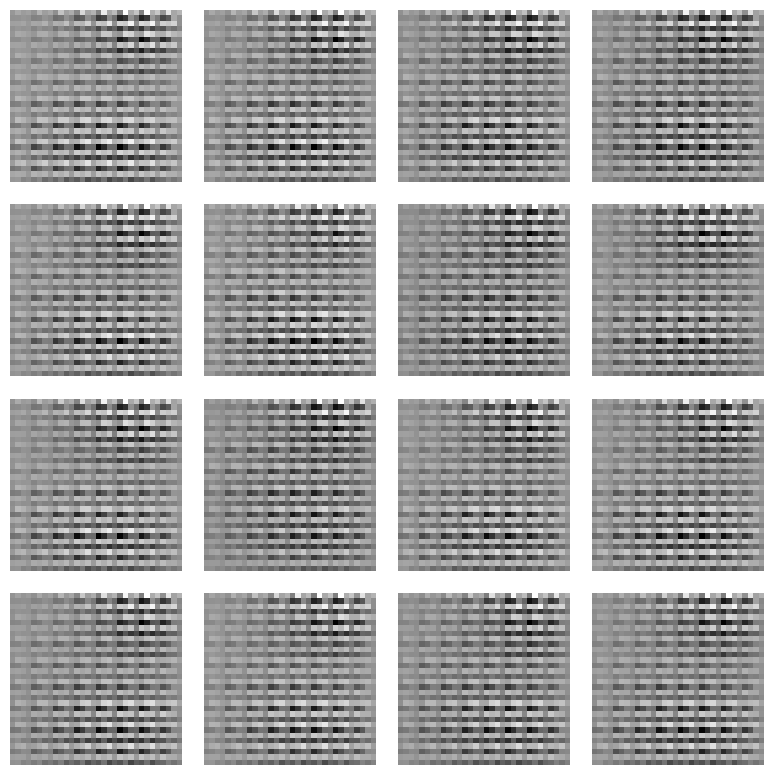

In [35]:
# samples = samples_recon.detach()

# Visualize generated samples
grid_size = make_grid(samples, nrow=4, padding=2)
# save_image(grid_size, "generated_samples.png", normalize=True)

print(grid_size.shape)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(num_samples):
    ax = axes[i // 4, i % 4]
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis("off")

plt.show()

## Sample build a model and demonstrate it

In [69]:
def initialize_flow(model):
    """
    Initialize a full normalizing flow model
    """
    for name, param in model.named_parameters():
        if "weight" in name:
            # Layer-dependent initialization
            if "coupling" in name:
                nn.init.normal_(param, mean=0.0, std=0.01)
            else:
                nn.init.xavier_uniform_(param)
        elif "bias" in name:
            nn.init.constant_(param, 0.0)



In [98]:
def get_model():
    n_hidden = 64
    n_glow_blocks = 3
    use_lu = True
    gamma = 1e-6
    activation = "linear"

    input_shape = (1, 32, 32)
    n_channels = input_shape[0]
    img_size = input_shape[1]

    n_chs = n_channels
    flows = []

    debug = True

    n_mixing_layers = 2
    n_injective_layers = 4
    n_layers = n_mixing_layers + n_injective_layers

    n_chs = int(n_channels * 4 ** n_mixing_layers * (1/2) ** n_injective_layers)
    print('Starting at latent representation: ', n_chs)
    latent_size = int(img_size / (2**n_mixing_layers))
    q0 = nf.distributions.DiagGaussian((n_chs, latent_size, latent_size))

    for i in range(n_injective_layers):
        if i == 0:
            split_mode = 'checkerboard'
        else:
            split_mode = 'channel'
            
        for j in range(n_glow_blocks):
            flows += [
                GlowBlock(
                    channels=n_chs,
                    hidden_channels=n_hidden,
                    use_lu=use_lu,
                    scale=True,
                    split_mode=split_mode
                )
            ]

        # input to inj flow is what is at the X -> V layer
        flows += [
            InjectiveGlowBlock(
                channels=n_chs,
                hidden_channels=n_hidden,
                activation=activation,
                scale=True,
                gamma=gamma,
                debug=debug,
                split_mode=split_mode,
            )
        ]
        n_chs = n_chs * 2
        if debug:
            print(f"On layer {n_layers - i}, n_chs = {n_chs//2} -> {n_chs}")

    for i in range(n_mixing_layers):
        for j in range(n_glow_blocks):
            flows += [
                GlowBlock(
                    channels=n_chs,
                    hidden_channels=n_hidden,
                    use_lu=use_lu,
                    scale=True,
                )
            ]
        flows += [Squeeze()]
        n_chs = n_chs // 4
        if debug:
            print(f"On layer {n_mixing_layers - i}, n_chs = {n_chs}")


    model = nf.NormalizingFlow(q0=q0, flows=flows)

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(pytorch_total_params)

    return model


In [99]:
flow_model = get_model()
samples = flow_model.q0.sample(16)
print(samples.shape)

glow_block = GlowBlock(1, 64, use_lu=True, scale=True, split_mode='checkerboard')
output, _ = glow_block.forward(samples)

print(output.shape)

Starting at latent representation:  1
On layer 6, n_chs = 1 -> 2
On layer 5, n_chs = 2 -> 4
On layer 4, n_chs = 4 -> 8
On layer 3, n_chs = 8 -> 16
On layer 2, n_chs = 4
On layer 1, n_chs = 1
145694
torch.Size([16, 1, 8, 8])
torch.Size([16, 1, 8, 8])


In [100]:
# set seed
seed = 12345
np.random.seed(seed)
pl.seed_everything(seed, workers=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    accelerator = "cuda"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    accelerator = "mps"
else:
    device = torch.device("cpu")
    accelerator = "cpu"

print(f"Using device: {device}")
print(f"Using accelerator: {accelerator}")

debug = False
fast_dev = False
max_epochs = 1000
if debug:
    accelerator = "cpu"
    fast_dev = True
    max_epochs = 1

batch_size = 128
n_steps_mse = 500
devices = 1
strategy = "auto"  # or ddp if distributed
num_workers = 4
gradient_clip_val = None  # 1.0
check_val_every_n_epoch = 5
monitor = "val_loss"

lr = 3e-4
lr_min = 1e-8
lr_scheduler = "cosine"

# whether or not to shuffle dataset
shuffle = True

# output filename for the results
root = "./data/"
model_name = "check_injflow_mnist_v2"
checkpoint_dir = Path("./results") / model_name
checkpoint_dir.mkdir(exist_ok=True, parents=True)

model_fname = f"{model_name}-model.pt"

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    save_top_k=5,
    monitor=monitor,
    every_n_epochs=check_val_every_n_epoch,
)


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logging.info(f"\n\n\tsaving to {model_fname} \n")

# Define the trainer
trainer = pl.Trainer(
    logger=False,
    max_epochs=max_epochs,
    devices=devices,
    strategy=strategy,
    callbacks=[checkpoint_callback, TwoStageTraining()],
    check_val_every_n_epoch=check_val_every_n_epoch,
    accelerator=accelerator,
    # fast_dev_run=fast_dev,
    # log_every_n_steps=1,
    # max_epochs=1,
    # limit_train_batches=1,
    # limit_val_batches=1,
)

# define the model
flow_model = get_model()
initialize_flow(flow_model)
model = plFlowModel(
    flow_model,
    lr=lr,
    lr_min=lr_min,
    lr_scheduler=lr_scheduler,
    n_steps_mse=n_steps_mse,
)

Seed set to 12345
INFO:root:

	saving to check_injflow_mnist_v2-model.pt 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Using device: mps
Using accelerator: mps
Starting at latent representation:  1
On layer 6, n_chs = 1 -> 2
On layer 5, n_chs = 2 -> 4
On layer 4, n_chs = 4 -> 8
On layer 3, n_chs = 8 -> 16
On layer 2, n_chs = 4
On layer 1, n_chs = 1
145694


/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [101]:

# sample the data
num_samples = 16
samples, _ = model.sample(num_samples)
print('Output images: ', samples.shape)

AffineCouplingBlock torch.Size([16, 1, 8, 8])
Injective1x1Conv torch.Size([16, 1, 8, 8])
ActNorm torch.Size([16, 2, 8, 8])
AffineCouplingBlock torch.Size([16, 2, 8, 8])
Injective1x1Conv torch.Size([16, 2, 8, 8])
ActNorm torch.Size([16, 4, 8, 8])
AffineCouplingBlock torch.Size([16, 4, 8, 8])
Injective1x1Conv torch.Size([16, 4, 8, 8])
ActNorm torch.Size([16, 8, 8, 8])
AffineCouplingBlock torch.Size([16, 8, 8, 8])
Injective1x1Conv torch.Size([16, 8, 8, 8])
ActNorm torch.Size([16, 16, 8, 8])
Output images:  torch.Size([16, 1, 32, 32])


torch.Size([3, 138, 138])


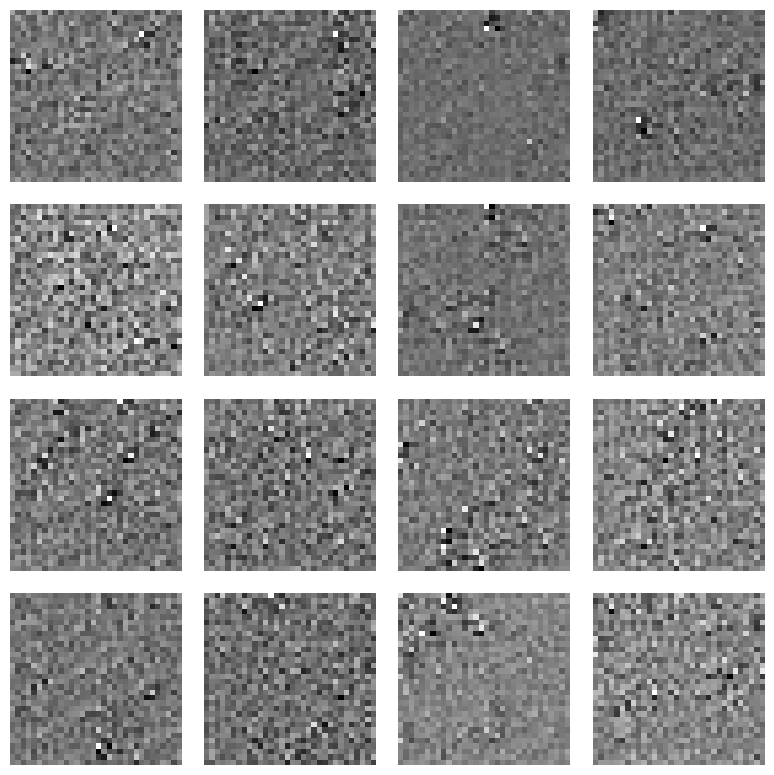

In [102]:
#  Visualize generated samples
grid_size = make_grid(samples, nrow=4, padding=2)

print(grid_size.shape)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(num_samples):
    ax = axes[i // 4, i % 4]
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis("off")

In [ ]:
# inspect 